In [50]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '..')
from analysis.analysis_utils import *
from analysis.plot_utils import *
import pandas as pd
from datasets import load_dataset
from collections import Counter
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
all_df = prepare_df()

# Add the debate leak check
checks_df = load_all_records_into_df('debate_checks').drop_duplicates(['run_id_debate_checks', 'record_id_debate_checks'], keep='last')
all_df = all_df.merge(checks_df, left_on=['debate_run_id_verdicts', 'record_id_verdicts'], right_on=['run_id_debate_checks', 'record_id_debate_checks'], how='left')

all_df['raw_verdict_response'] = all_df['judge_verdict_verdicts'].apply(lambda x: x['raw_response'])



In [36]:
def get_argument_lengths(debate_history):
    lengths = []
    try:
        for entry in debate_history:
            entry_len = len(entry['raw_response'].split())
            lengths.append(entry_len)
    except:
        return None

    return np.array(lengths)

all_df['debate_argument_lengths'] = all_df['debate_history_debates'].apply(lambda x: get_argument_lengths(x))
all_df = all_df[all_df['debate_argument_lengths'].notnull()]

In [37]:
all_df.shape

(24120, 90)

## Look at single run

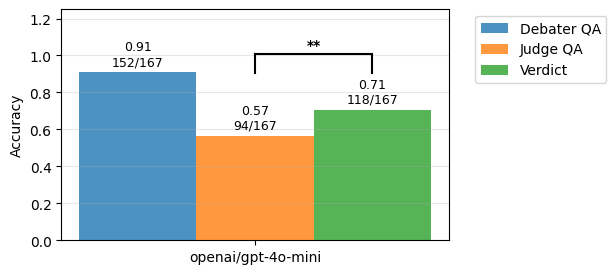

In [ ]:

single_verdict =  ['k26y5y6'] # grok-4-fast as debater (4 choice)
verdicts_df = all_df[all_df['verdict_run_id_verdicts'].isin(single_verdict)]
# 
verdicts_df = verdicts_df[verdicts_df['has_leak_debate_checks'] == False]

acc_gpqa = aggregate_by_fields(verdicts_df, ['config_judge_model_verdicts'])


ax, plt = plot_accuracy_bars_single(acc_gpqa, show_sig=True)

In [ ]:
# verdicts_df[['is_correct_qa_debater', 'is_correct_qa_judge', 'is_correct_verdict']].value_counts().reset_index()
verdicts_df[['is_correct_qa_judge', 'is_correct_verdict']].value_counts().reset_index()


,is_correct_qa_judge,is_correct_verdict,count
0,True,True,73
1,False,True,44
2,False,False,28
3,True,False,21


In [ ]:
# tft are the main successes and ttf are the main failures
tft = verdicts_df[(verdicts_df['is_correct_qa_debater'] == True) & (verdicts_df['is_correct_qa_judge'] == False) & (verdicts_df['is_correct_verdict'] == True)]
ttf = verdicts_df[(verdicts_df['is_correct_qa_debater'] == True) & (verdicts_df['is_correct_qa_judge'] == True) & (verdicts_df['is_correct_verdict'] == False)]

In [ ]:
tft['record_id_verdicts'].tolist()[:2]

['ky8qkpj', 'f1jkw43']

In [ ]:
ttf['record_id_verdicts'].tolist()[:2]

['uwndxoj', '8uee8as']

### Analysis

##### Does phrase vagueness in the judge verdict indicate correctness?

In [ ]:
def check_for_vague_phrases(x):
    if 'more plausible' in x or 'more consistent' in x:
        return True
    else:
        return False

all_df['vague_phrase'] = all_df['raw_verdict_response'].apply(lambda x: check_for_vague_phrases(x))

verdicts_df = all_df[all_df['config_judge_model_verdicts'] == 'openai/gpt-4o-mini'].copy()


In [ ]:
verdicts_df[['vague_phrase', 'config_judge_model_verdicts']].value_counts().reset_index()

,vague_phrase,config_judge_model_verdicts,count
0,False,openai/gpt-4o-mini,4206
1,True,openai/gpt-4o-mini,788


In [ ]:
tft = verdicts_df[(verdicts_df['is_correct_qa_debater'] == True) & (verdicts_df['is_correct_qa_judge'] == False) & (verdicts_df['is_correct_verdict'] == True)]
ttf = verdicts_df[(verdicts_df['is_correct_qa_debater'] == True) & (verdicts_df['is_correct_qa_judge'] == True) & (verdicts_df['is_correct_verdict'] == False)]

In [ ]:
tft['vague_phrase'].value_counts(normalize=True)

vague_phrase
False    0.788609
True     0.211391
Name: proportion, dtype: float64

In [ ]:
ttf['vague_phrase'].value_counts(normalize=True)

vague_phrase
False    0.796673
True     0.203327
Name: proportion, dtype: float64

Conclusion: inclusion of these vague phrases does not correlate with working or not working

##### Does judge verdict length correlate with correctness?

In [53]:
all_df['verdict_response_len'] = all_df['raw_verdict_response'].apply(lambda x: len(x.split()))

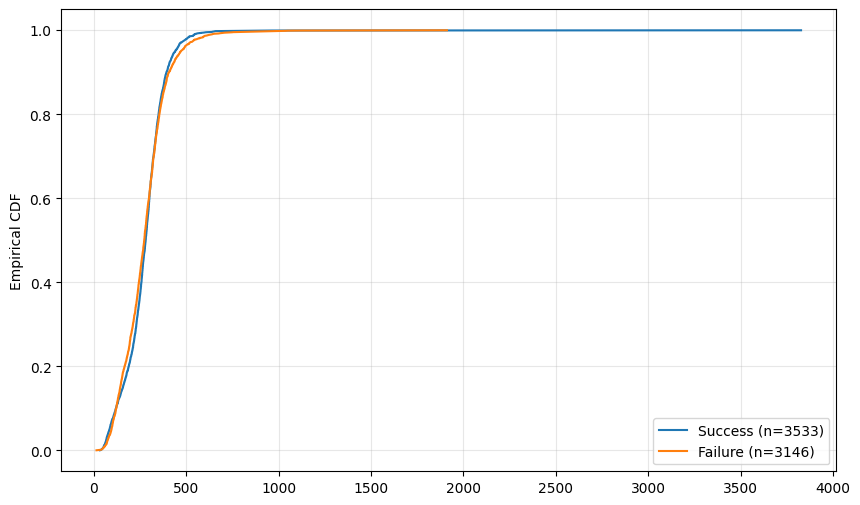

In [ ]:
tft = all_df[(all_df['is_correct_qa_debater'] == True) & (all_df['is_correct_qa_judge'] == False) & (all_df['is_correct_verdict'] == True)]
ttf = all_df[(all_df['is_correct_qa_debater'] == True) & (all_df['is_correct_qa_judge'] == True) & (all_df['is_correct_verdict'] == False)]

# tft_sorted = np.sort(tft['verdict_response_len'].dropna())
# ttf_sorted = np.sort(ttf['verdict_response_len'].dropna())

def cdf(d1, d2, ax=None, smart_xlim=True):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    d1 = np.sort(d1.dropna().copy())
    d2 = np.sort(d2.dropna().copy())
    ax.plot(d1, np.arange(1, len(d1) + 1) / len(d1), label=f'Success (n={len(d1)})')
    ax.plot(d2, np.arange(1, len(d2) + 1) / len(d2), label=f'Failure (n={len(d2)})')
    ax.set_ylabel('Empirical CDF')
    ax.legend()
    ax.grid(True, alpha=0.3)
    return ax

cdf(tft['verdict_response_len'], ttf['verdict_response_len'])
plt.show()

### Does debater argument length correlate with correctness?

In [38]:
verdicts_df = all_df[all_df['config_num_choices_debates'] == 2].copy()
verdicts_df.shape

(5936, 90)

In [39]:
verdicts_df['total_argument_lengths'] = verdicts_df['debate_argument_lengths'].apply(lambda x: x.sum())
verdicts_df['absolute_length_differences'] = verdicts_df['debate_argument_lengths'].apply(lambda x: abs(x[0] - x[1]))
verdicts_df['correct_choice_length'] = verdicts_df.apply(lambda row: row['debate_argument_lengths'][row['correct_idx_verdicts']], axis=1)
verdicts_df['incorrect_choice_length'] = verdicts_df.apply(lambda row: row['debate_argument_lengths'][1 - row['correct_idx_verdicts']], axis=1)
verdicts_df['correct_minus_incorrect_length'] = verdicts_df['correct_choice_length'] - verdicts_df['incorrect_choice_length']


In [40]:
verdicts_df.shape

(5936, 95)

In [97]:
tft = verdicts_df[(verdicts_df['is_correct_qa_debater'] == True) & (verdicts_df['is_correct_qa_judge'] == False) & (verdicts_df['is_correct_verdict'] == True)]
ttf = verdicts_df[(verdicts_df['is_correct_qa_debater'] == True) & (verdicts_df['is_correct_qa_judge'] == True) & (verdicts_df['is_correct_verdict'] == False)]

In [98]:
tft[['total_argument_lengths', 'absolute_length_differences', 'correct_choice_length', 'incorrect_choice_length', 'correct_minus_incorrect_length']].describe()

,total_argument_lengths,absolute_length_differences,correct_choice_length,incorrect_choice_length,correct_minus_incorrect_length
count,1148.000000,1148.000000,1148.000000,1148.000000,1148.000000
mean,433.806620,30.423345,207.918990,225.887631,-17.968641
std,281.121389,43.159709,133.224949,151.653314,49.658773
min,39.000000,0.000000,20.000000,19.000000,-516.000000
25%,324.500000,8.000000,154.000000,162.000000,-32.000000
50%,357.000000,20.000000,175.000000,186.000000,-13.000000
75%,416.000000,35.000000,204.000000,222.000000,4.000000
max,1911.000000,516.000000,891.000000,1186.000000,197.000000


In [99]:
ttf[['total_argument_lengths', 'absolute_length_differences', 'correct_choice_length', 'incorrect_choice_length', 'correct_minus_incorrect_length']].describe()

,total_argument_lengths,absolute_length_differences,correct_choice_length,incorrect_choice_length,correct_minus_incorrect_length
count,766.000000,766.000000,766.000000,766.000000,766.000000
mean,398.770235,30.467363,195.314621,203.455614,-8.140992
std,253.988460,118.179783,161.180746,117.006932,121.776731
min,45.000000,0.000000,19.000000,26.000000,-458.000000
25%,317.000000,9.000000,154.000000,163.000000,-25.000000
50%,347.000000,19.000000,168.000000,179.000000,-11.000000
75%,385.750000,32.000000,190.750000,200.000000,4.000000
max,3973.000000,3133.000000,3553.000000,910.000000,3133.000000


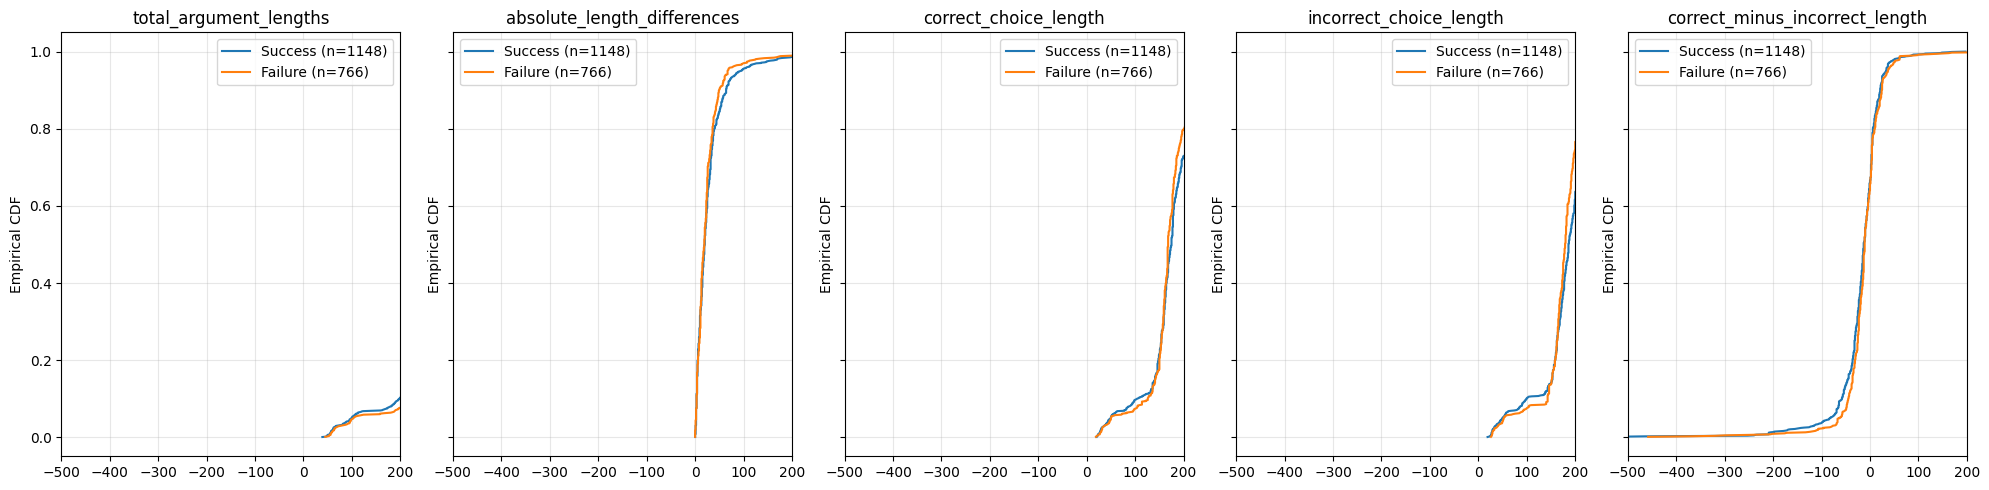

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(20, 5), sharey=True)
plot_types = ['total_argument_lengths', 'absolute_length_differences', 'correct_choice_length', 'incorrect_choice_length', 'correct_minus_incorrect_length']
for ax_index in range(5):
    cdf(tft[plot_types[ax_index]], ttf[plot_types[ax_index]], ax[ax_index], smart_xlim=True)
    ax[ax_index].set_title(plot_types[ax_index])
plt.tight_layout()
plt.show()